In [1]:
# import libraries
import os
import requests

import tensorflow as tf
import pandas as pd
from tensorflow import keras
from keras import layers

import numpy as np
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

In [2]:
def load_tsv(file_path):
    url = f'https://cdn.freecodecamp.org/project-data/sms/{file_path}'
    if not os.path.exists(file_path):
        response = requests.get(url)
        with open(file_path, 'wb') as file:
            file.write(response.content)

In [3]:
# get data files
train_file_path = "train-data.tsv"
test_file_path = "valid-data.tsv"

load_tsv(train_file_path)
load_tsv(test_file_path)

In [4]:
train_df = pd.read_csv(train_file_path, sep='\t', names=['label', 'text'])
train_df.head()

,label,text
0,ham,ahhhh...just woken up!had a bad dream about u ...
1,ham,you can never do nothing
2,ham,"now u sound like manky scouse boy steve,like! ..."
3,ham,mum say we wan to go then go... then she can s...
4,ham,never y lei... i v lazy... got wat? dat day ü ...


In [5]:
test_df = pd.read_csv(test_file_path, sep='\t', names=['label', 'text'])
test_df.head()                     

,label,text
0,ham,i am in hospital da. . i will return home in e...
1,ham,"not much, just some textin'. how bout you?"
2,ham,i probably won't eat at all today. i think i'm...
3,ham,don‘t give a flying monkeys wot they think and...
4,ham,who are you seeing?


In [7]:
train_df.isna().sum()

label    0
text     0
dtype: int64

In [24]:
print(f'The number of duplicates in the training data is {train_df.duplicated().sum()}.')
train_df[train_df.duplicated(keep=False)].sort_values('text').head(10)

The number of duplicates in the training data is 244.


,label,text
996,0,1) go to write msg 2) put on dictionary mode 3...
3089,0,1) go to write msg 2) put on dictionary mode 3...
3707,0,1) go to write msg 2) put on dictionary mode 3...
953,1,18 days to euro2004 kickoff! u will be kept in...
523,1,18 days to euro2004 kickoff! u will be kept in...
1477,0,7 wonders in my world 7th you 6th ur style 5th...
2196,0,7 wonders in my world 7th you 6th ur style 5th...
1133,0,7 wonders in my world 7th you 6th ur style 5th...
1093,0,a boy loved a gal. he propsd bt she didnt mind...
36,0,a boy loved a gal. he propsd bt she didnt mind...


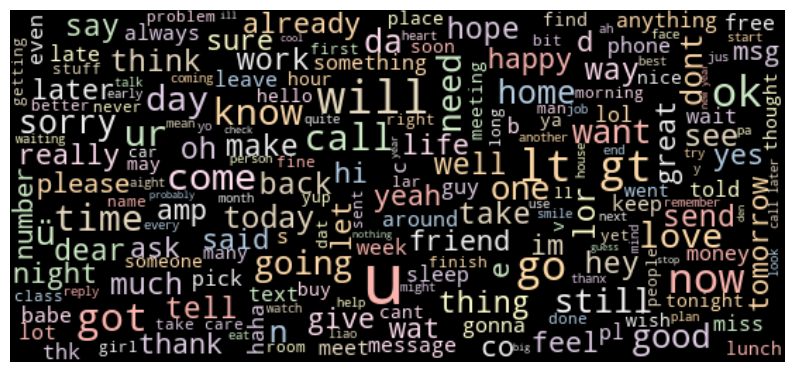

In [18]:
# To get a better understanding of the data, we can visualize the most popular words in the ham text messages
ham_text = " ".join(train_df.text[train_df.label == 'ham'].to_numpy().tolist())
ham_cloud = WordCloud(width =550, height =250, stopwords=STOPWORDS,
                      max_font_size=50, background_color ="black", colormap='Pastel1').generate(ham_text)
plt.figure(figsize=(10, 5))
plt.imshow(ham_cloud, interpolation='bilinear')
plt.axis("off")
plt.show()

count    68033.000000
mean         4.004615
std          2.608681
min          0.000000
25%          2.000000
50%          4.000000
75%          5.000000
max         52.000000
dtype: float64

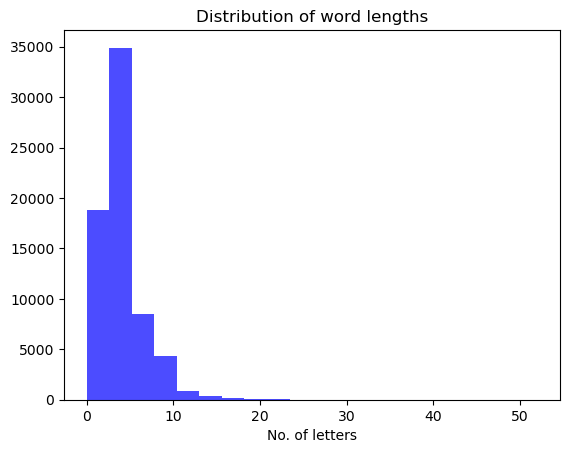

In [25]:
# We calculate the distribution of the lengths of each word in the text messages (No. of letters of each word)
import re
word_lengths = train_df.text.apply(lambda x: [len(word) for word in re.split(r'[,!\s]',x)])
all_lengths = [length for lengths in word_lengths for length in lengths]
plt.hist(all_lengths, bins=20, color='blue', alpha=0.7)
plt.title('Distribution of word lengths')
plt.xlabel('No. of letters')
pd.Series(all_lengths).describe()

In [19]:
train_df.label.value_counts()

label
ham     3619
spam     560
Name: count, dtype: int64

We observe that the labels are imbalanced.
* We could reduce the number of instances of the majority class (ham) to match the minority class (spam). (Undersampling)
* Or increase the number of instances in spam, either by duplicating instances or generating synthetic samples ([SMOTE](https://www.geeksforgeeks.org/ml-handling-imbalanced-data-with-smote-and-near-miss-algorithm-in-python/)). (Oversampling)
* Instead of accuracy, different metrics could be used, such as recall, F1 score, ROC that are more informative with imbalanced datasets.
* Also utilizing algorithms that are more robust to imbalanced datasets like Random Forest or boosting algos could be of use.  
In this example, we'll move forward for the sake of simplicity and return later if necessary.

In [6]:
# Encode the labels
train_df['label'] = train_df['label'].map({'ham': 0, 'spam': 1})
test_df['label'] = test_df['label'].map({'ham': 0, 'spam': 1})

## Baseline Model 
#### Bag of Words, Logistic Regression  
We cannot directly feed our text into algorithms. Hence, Bag of Words model is used to preprocess the text by converting it into a bag of words, which keeps a count of the total occurrences of most frequently used words.

* Specifically we:
    * convert text to lower case
    * remove all non-word characters
    * remove stopwords ('the','in', 'you', ...)
    * apply lemmatization (better -> good, went -> go)

In [6]:
import re

import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [28]:
def text_preprocessing(text):
    # Remove all the special characters
    text = re.sub('[^a-zA-Z]', ' ', text)
    # Lowercase all the words
    text = text.lower().split()

    # tokenization could be done in one step by using the following line instead:
    # from nltk.tokenize import word_tokenize
    # ntlk.download('punkt')
    # tokens = word_tokenize(text)

    # Remove stopwords then stem remaining words
    lemmatizer = WordNetLemmatizer()
    text = [lemmatizer.lemmatize(word) for word in text if not word in stopwords.words('english')]
    processed_text = ' '.join(text)
    return processed_text

In [29]:
# Run only if further preprocessing is needed, otherwise skip to the next cell
train_df.text = train_df.text.apply(text_preprocessing)
test_df.text = test_df.text.apply(text_preprocessing)
train_df.head()

,label,text
0,0,ahhhh woken bad dream u tho dont like u right ...
1,0,never nothing
2,0,u sound like manky scouse boy steve like trave...
3,0,mum say wan go go shun bian watch da glass exh...
4,0,never lei v lazy got wat dat day send da url c...


#### CountVectorizer 
The above procedure can alternatively be implemented by CountVectorizer instead which encompasses some of these preprocessing steps.

In [27]:
# Example of a message 

# It takes the words of each sentence and creates a vocabulary of all the unique words in the sentences. 
# This vocabulary can then be used to create a feature vector of the count of the words:

from sklearn.feature_extraction.text import CountVectorizer

corpus = ['This is the first document.',
        'This document is the second document.',
        'And this is the third one.',
        'Is this the first document?']

vectorizer = CountVectorizer()
print(vectorizer.fit_transform(corpus).toarray())
vectorizer.get_feature_names_out()

[[0 1 1 1 0 0 1 0 1]
 [0 2 0 1 0 1 1 0 1]
 [1 0 0 1 1 0 1 1 1]
 [0 1 1 1 0 0 1 0 1]]


array(['and', 'document', 'first', 'is', 'one', 'second', 'the', 'third',
       'this'], dtype=object)

In [38]:
from sklearn.feature_extraction.text import CountVectorizer

X_train = train_df.text.values
y_train = train_df.label.values
X_test = test_df.text.values
y_test = test_df.label.values

vectorizer = CountVectorizer()
vectorizer.fit(X_train)

X_train = vectorizer.transform(X_train)
X_test = vectorizer.transform(X_test)

# (Training samples, vocabulary size) -> (4179, 7445) when using the CountVectorizer without our custom preprocessing
X_train.shape

(4179, 7445)

Accuracy: 0.978448275862069
              precision    recall  f1-score   support

           0       0.98      1.00      0.99      1205
           1       0.98      0.86      0.91       187

    accuracy                           0.98      1392
   macro avg       0.98      0.93      0.95      1392
weighted avg       0.98      0.98      0.98      1392



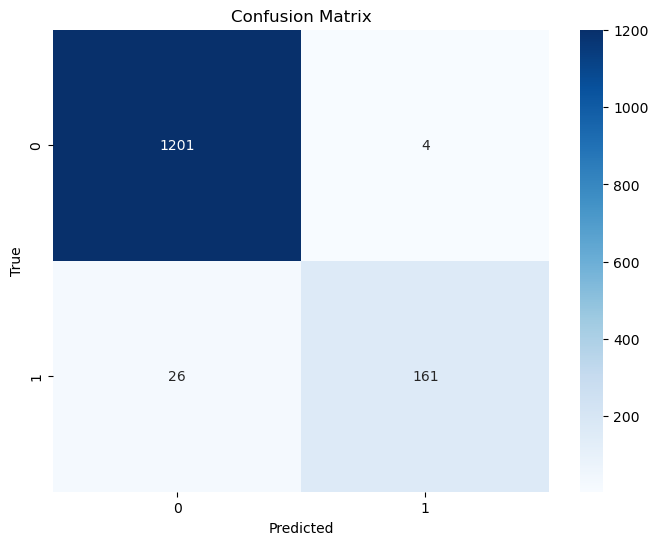

In [39]:
# Logistic Regression Classifier is chosen as our baseline model
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

classifier = LogisticRegression()
classifier.fit(X_train, y_train)

score = classifier.score(X_test, y_test)

print(f'Accuracy: {score}')

probs = classifier.predict_proba(X_test)
predicted_labels = np.argmax(probs, axis=1)

print(classification_report(y_test, predicted_labels))

# Confusion matrix
cm = confusion_matrix(y_test, predicted_labels)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

We note that the minority class's recall is somewhat lower than the majority's, leading us to conclude that the model is slightly biased in favor of the majority class. Hence for the sake of simplicity, there is no need to balance the dataset.

## Word embeddings (TextVectorization and Embedding layers ++)
In the previous BOW model, we have seen how to represent a whole sequence of words as a single feature vector. Now we will see how to represent each word as vectors.  
Words are represented as dense word vectors (word embeddings) which are trained unlike the one-hot encoding which are hardcoded. This means that the word embeddings collect more information into fewer dimensions, mapping semantically similar words close on the embedding space like numbers or colors.  
We've seen that the maximum vocab_size is 7445 or 6055, if preprocessed, in training set.

count    4179.000000
mean       15.604451
std        11.492907
min         1.000000
25%         7.000000
50%        12.000000
75%        23.000000
max       171.000000
Name: text, dtype: float64

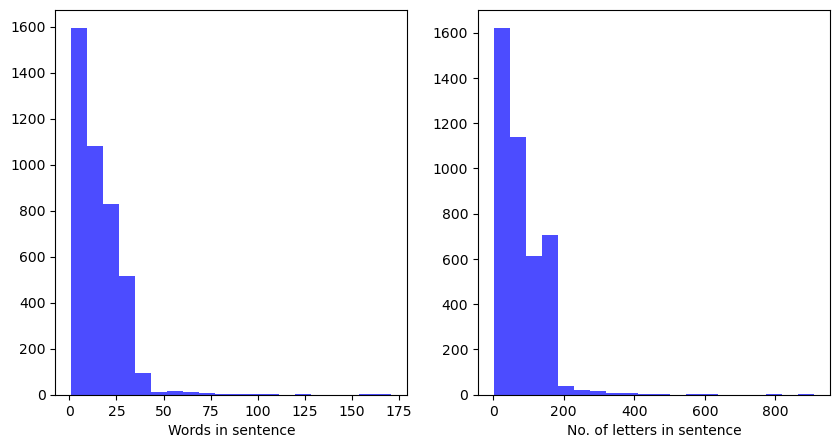

In [8]:
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
words_in_text = train_df.text.apply(lambda x: len(x.split()))
plt.hist(words_in_text, bins=20, color='blue', alpha=0.7)
plt.xlabel('Words in sentence')

plt.subplot(1,2,2)
seq_len = train_df.text.apply(lambda x: len(x))
plt.hist(seq_len, bins=20, color='blue', alpha=0.7)
plt.xlabel('No. of letters in sentence')
words_in_text.describe()

In [9]:
# Useful for setting the max length of the input sequence
np.percentile(words_in_text, 95)

32.0

In [10]:
import re

import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [11]:
# Custom preprocessing function for the TextVectorization layer 
'''ISSUE: (if we ommit lemmatization and stopwords removal it works in the vectorize_layer and
 there is no need to apply it manually to the train and test dataframes)'''
#  tf.config.run_functions_eagerly(True)

def custom_prepro(input_data):
    # Convert to lowercase
    lowercase = tf.strings.lower(input_data)

    # Keep only letters
    no_punct = tf.strings.regex_replace(lowercase, '[^a-zA-Z]', ' ')

    # Tokenize the string into words
    words = tf.strings.split(no_punct)

    # Remove stopwords
    # stop_words = set(stopwords.words('english'))
    # words = [word for word in words if word not in stopwords.words('english')]

    # Lemmatization
    lemmatizer = WordNetLemmatizer()
    # words = [lemmatizer.lemmatize(word) for word in words]
    
    words = [lemmatizer.lemmatize(word.numpy().decode('utf-8')) 
             for word in words if word.numpy().decode('utf-8') not in stopwords.words('english')]
    
    # Join the words back into a single string
    preprocessed_text = ' '.join(words)

    return preprocessed_text

In [12]:
max_features = 3000 # Only consider the top 3k words
sequence_length = 32 # As indicated by the 95th percentile of the words_in_text distribution

vectorize_layer = layers.TextVectorization(
    # standardize=custom_prepro,
    max_tokens=max_features,
    output_mode='int',
    output_sequence_length=sequence_length)

In [13]:
train_df.text = train_df.text.apply(custom_prepro)
test_df.text = test_df.text.apply(custom_prepro)

In [14]:
# When this layer is adapted, it will analyze the dataset, determine the frequency of individual string values, 
# and create a vocabulary from them.
vectorize_layer.adapt(train_df.text.tolist())

In [11]:
# Example
print("Original text:", train_df.text[0])
print("Preprocessed text:", custom_prepro(train_df.text[0]))
print("Vectorized preprocessed text:", vectorize_layer([custom_prepro(train_df.text[0])]))

Original text: ahhhh...just woken up!had a bad dream about u tho,so i dont like u right now :) i didnt know anything about comedy night but i guess im up for it.
Preprocessed text: ahhhh woken bad dream u tho dont like u right didnt know anything comedy night guess im
Vectorized preprocessed text: tf.Tensor(
[[   1 2425  404  824    7  731   47   57    7  153  177   56  165 2256
   107  302   23    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0]], shape=(1, 32), dtype=int64)


## Dense Model
* The TextVectorization layer transforms strings into vocabulary indices.
* The Embedding layer takes the integer-encoded vocabulary and looks up the embedding vector for each word-index.
* The GlobalAveragePooling1D layer returns a fixed-length output vector for each example by averaging over the sequence dimension. This allows the model to handle input of variable length.  
* In the embedding layer, the 48000 parameter comes from 3000 words (vocab_size), each one with a 16 dimensional word-vector space (3000 x 16 = 48000).
* We selected 16 neurons for the dense hidden layer and each one gets input from each of the 16 values coming from the GlobalAveragePooling1D layer, for a total of 256 (16 x 16) weights and 16 biases, hence (16 x 16 + 16 = 272).
* Similarly the oputput layer has (16 x 2 + 2 = 34) parameters, since we've got 2 neurons. 

In [15]:
embedding_dim = 16
model = keras.Sequential([
  vectorize_layer,
  layers.Embedding(input_dim=max_features, output_dim=embedding_dim, input_length=sequence_length),
  layers.GlobalAveragePooling1D(),
  layers.Dense(16, activation='relu'),
  layers.Dense(2, activation='sigmoid')
])
model.summary()
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
history = model.fit(
    train_df.text, train_df.label,
    validation_split = 0.2,
    epochs=15)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVec  (None, 32)               0         
 torization)                                                     
                                                                 
 embedding (Embedding)       (None, 32, 16)            48000     
                                                                 
 global_average_pooling1d (G  (None, 16)               0         
 lobalAveragePooling1D)                                          
                                                                 
 dense (Dense)               (None, 16)                272       
                                                                 
 dense_1 (Dense)             (None, 2)                 34        
                                                                 
Total params: 48,306
Trainable params: 48,306
Non-traina

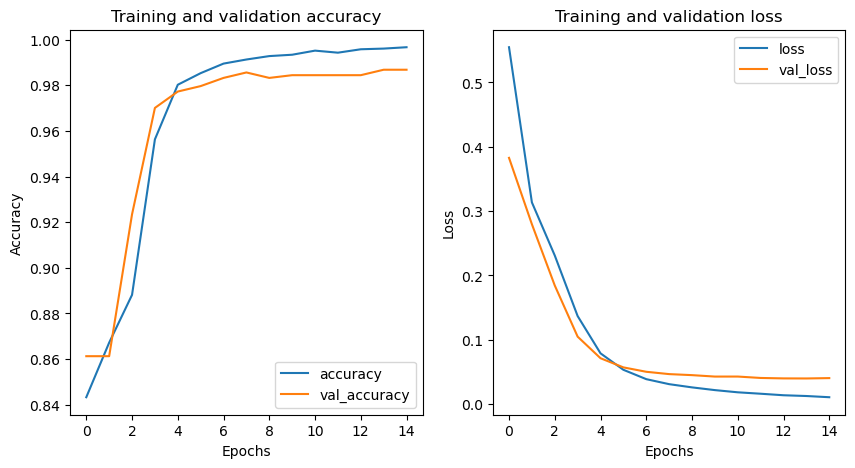

In [16]:
def plot_graphs(history, string):
    plt.plot(history.history[string])
    plt.plot(history.history['val_'+string], '')
    plt.title('Training and validation '+string)
    plt.xlabel('Epochs')
    plt.ylabel(string.title())
    plt.legend([string, 'val_'+string])
    

plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plot_graphs(history, 'accuracy')
plt.subplot(1,2,2)
plot_graphs(history, 'loss')

In [17]:
loss, accuracy = model.evaluate(test_df.text, test_df.label)

44/44 [==============================] - 0s 1ms/step - loss: 0.0308 - accuracy: 0.9899


In [95]:
probabilities = model.predict(test_df.text, verbose=0)
predictions = np.argmax(probabilities, axis=1)

* Instead of training our own embedding, we can use a precomputed embedding space that utilizes a much larger corpus like the [Word2Vec](chrome-extension://efaidnbmnnnibpcajpcglclefindmkaj/https://proceedings.neurips.cc/paper_files/paper/2013/file/9aa42b31882ec039965f3c4923ce901b-Paper.pdf) developed by Google or [GloVe](https://nlp.stanford.edu/projects/glove/) by the Stanford NLP Group.
* We can either allow the resulting embedding vectors to be updated during training or use them as they are.
* Lastly, more sophisticated model architectures could have been used, like a [Bidirectional RNN](https://www.tensorflow.org/text/tutorials/text_classification_rnn) layer or even a [Convolutional](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv1D) one.

In [18]:
# function to predict messages based on model
# (should return list containing prediction and label, ex. [0.008318834938108921, 'ham'])
def predict_message(pred_text):
    
    pred_text = pd.Series(pred_text).apply(custom_prepro)
    probabilities = model.predict([pred_text], verbose=0)
    
    pred = np.argmax(probabilities, axis=1)
    
    prediction = [float(probabilities[0,pred]), 'ham' if pred == 0 else 'spam']
    return prediction

pred_text = "how are you doing today"

prediction = predict_message(pred_text)
print(prediction)

[0.8930834531784058, 'ham']


In [19]:
# Run this cell to test your function and model. Do not modify contents.
def test_predictions():
  test_messages = ["how are you doing today",
                   "sale today! to stop texts call 98912460324",
                   "i dont want to go. can we try it a different day? available sat",
                   "our new mobile video service is live. just install on your phone to start watching.",
                   "you have won £1000 cash! call to claim your prize.",
                   "i'll bring it tomorrow. don't forget the milk.",
                   "wow, is your arm alright. that happened to me one time too"
                  ]

  test_answers = ["ham", "spam", "ham", "spam", "spam", "ham", "ham"]
  passed = True

  for msg, ans in zip(test_messages, test_answers):
    prediction = predict_message(msg)
    if prediction[1] != ans:
      passed = False

  if passed:
    print("You passed the challenge. Great job!")
  else:
    print("You haven't passed yet. Keep trying.")

test_predictions()


You passed the challenge. Great job!
